This notebook demonstrates how to use wobble to analyse data from the MAROON-X spectrograph.

btm 2020/04/16

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import wobble

from tqdm import tqdm
import astropy.time as atime
import h5py
import glob

In [2]:
import matplotlib as mpl
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['figure.figsize'] = (12.0, 4.0)

In [3]:
filenames_b = glob.glob('data/MAROON-X/LTT1445/*/*_b_*.hdf')  # get all files
filenames_r = glob.glob('data/MAROON-X/LTT1445/*/*_r_*.hdf')

In [4]:
filenames_b.sort()  # sort. Since their filenames are by time, this will also match up red and blue frames
filenames_r.sort()  # which glob might not do automatically. In a future where the naming is uniform we could
                    # change how this is input. We also need to be careful that the observations really are 
                    # one-to-one between the two arms; if they are not in the future that will also require a
                    # re-think.

In [5]:
data = wobble.Data() # initialise 

load in all files. To speed things up you may want to only consider a slice.

In [6]:
for i, filename in enumerate(tqdm(filenames_b)):
    try:
        fiberlist = filename.split('_')[-3:-2][0]
        for fiber in range(1,6):
            sp = wobble.Spectrum()
            if fiberlist[fiber-1] == 'O':        
                sp.from_MAROON_X(filename, filenames_r[i], fiber, process=True)
                data.append(sp)
    except Exception as e:
        print("File {0} failed; error: {1}".format(filename, e))
        

  0%|          | 0/27 [00:00<?, ?it/s]/Users/bmontet/research/tools/wobble/wobble/data.py:364: RuntimeWarning: invalid value encountered in less
  bad = np.logical_or(self.ys[r] < min_flux, ~np.isfinite(self.ys[r]))
100%|██████████| 27/27 [00:58<00:00,  2.25s/it]


In [7]:
#data.write('ltt1445.hdf5')  # to save the array rather than re-creating it each time you want to run the notebook

Note: in changing how the data are read in to get the red arm data I appear to have broken the writer

In [8]:
#best_ords = np.delete(np.arange(0, 32, 1), [6, 7, 12, 13])

#data = wobble.Data('hd209.hdf5', orders=best_ords)  # only need to run this cell if we're loading in previously saved data, in this case to cut some orders

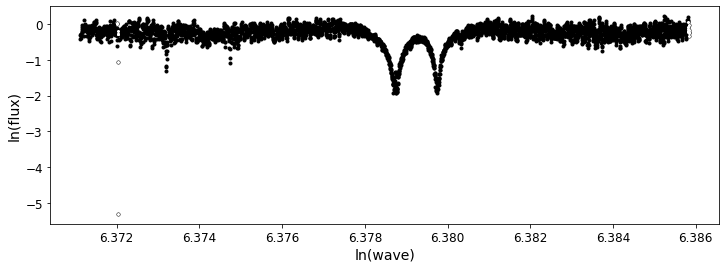

In [9]:
r = 13#  index of echelle order to plot
n = 0 # index of epoch to plot
plt.plot(data.xs[r][n], data.ys[r][n], 'k.', ms=6)
mask = data.ivars[r][n] <= 1.e-8 # masked-out bad data
plt.plot(data.xs[r][n][mask], data.ys[r][n][mask], 'w.', ms=4)
plt.ylabel('ln(flux)')
plt.xlabel('ln(wave)');

In [10]:
results = wobble.Results(data=data)


In [11]:
r = 104 - 91
model = wobble.Model(data, results, r)
model.add_star('star')
model.add_telluric('tellurics')
wobble.optimize_order(model)    # run for a single order

  0%|          | 0/100 [00:00<?, ?it/s]

optimize: iterating through 100 optimization steps...


  0%|          | 0/81 [00:00<?, ?it/s]

optimize: calculating uncertainties on star rvs...


100%|██████████| 81/81 [00:05<00:00, 16.09it/s]


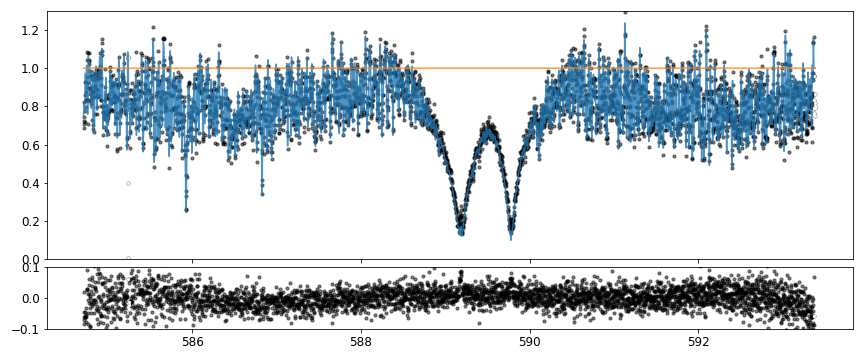

In [12]:
n = 2 # epoch to plot
results.plot_spectrum(r, n, data, 'test.png')
from IPython.display import Image
Image(filename='test.png')

In [13]:
results2 = wobble.Results(data=data)
model = wobble.Model(data, results2, r)
model.add_star('star')
model.add_telluric('tellurics', variable_bases=2)
wobble.optimize_order(model)  # run for a single order

  0%|          | 0/100 [00:00<?, ?it/s]

optimize: iterating through 100 optimization steps...


  0%|          | 0/81 [00:00<?, ?it/s]

optimize: calculating uncertainties on star rvs...


100%|██████████| 81/81 [00:03<00:00, 20.39it/s]


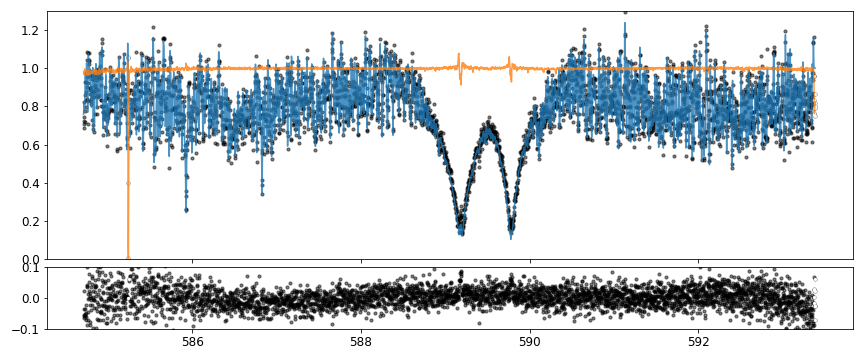

In [14]:
results2.plot_spectrum(r, n, data, 'test2.png')
Image(filename='test2.png')

Text(0, 0.5, 'RV (m s$^{-1}$)')

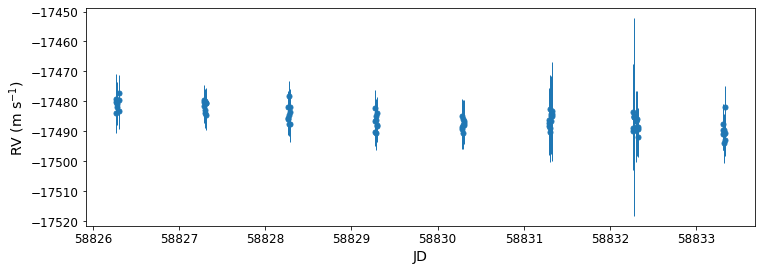

In [15]:
# plot for a single order

plt.errorbar(results.dates, results.star_rvs[r] + results.bervs,   
             1./np.sqrt(results.star_ivars_rvs[r]), 
             fmt='o', ms=5, elinewidth=1)
plt.xlabel('JD') 
plt.ylabel(r'RV (m s$^{-1}$)')
#plt.xlim([2456505, 2456570]);

Now we can run for all orders. This can take a little while, so for testing you may want to limit the number of orders used!

In [16]:
results = wobble.Results(data=data)
for r in range(len(data.orders)):
    print('starting order {0} of {1}'.format(r+1, len(data.orders)))
    model = wobble.Model(data, results, r)
    model.add_star('star')
    model.add_telluric('tellurics', variable_bases=2)
    wobble.optimize_order(model)

starting order 1 of 60


  0%|          | 0/100 [00:00<?, ?it/s]

optimize: iterating through 100 optimization steps...


  0%|          | 0/81 [00:00<?, ?it/s]

optimize: calculating uncertainties on star rvs...


100%|██████████| 81/81 [00:03<00:00, 22.00it/s]


starting order 2 of 60


  0%|          | 0/100 [00:00<?, ?it/s]

optimize: iterating through 100 optimization steps...


  0%|          | 0/81 [00:00<?, ?it/s]

optimize: calculating uncertainties on star rvs...


100%|██████████| 81/81 [00:03<00:00, 22.08it/s]


starting order 3 of 60


  0%|          | 0/100 [00:00<?, ?it/s]

optimize: iterating through 100 optimization steps...


  0%|          | 0/81 [00:00<?, ?it/s]

optimize: calculating uncertainties on star rvs...


100%|██████████| 81/81 [00:03<00:00, 22.67it/s]


starting order 4 of 60


  0%|          | 0/100 [00:00<?, ?it/s]

optimize: iterating through 100 optimization steps...


  0%|          | 0/81 [00:00<?, ?it/s]

optimize: calculating uncertainties on star rvs...


100%|██████████| 81/81 [00:03<00:00, 22.25it/s]


starting order 5 of 60


  0%|          | 0/100 [00:00<?, ?it/s]

optimize: iterating through 100 optimization steps...


  0%|          | 0/81 [00:00<?, ?it/s]

optimize: calculating uncertainties on star rvs...


100%|██████████| 81/81 [00:03<00:00, 22.20it/s]


starting order 6 of 60


  0%|          | 0/100 [00:00<?, ?it/s]

optimize: iterating through 100 optimization steps...


  0%|          | 0/81 [00:00<?, ?it/s]

optimize: calculating uncertainties on star rvs...


100%|██████████| 81/81 [00:03<00:00, 22.08it/s]


starting order 7 of 60


  0%|          | 0/100 [00:00<?, ?it/s]

optimize: iterating through 100 optimization steps...


  0%|          | 0/81 [00:00<?, ?it/s]

optimize: calculating uncertainties on star rvs...


100%|██████████| 81/81 [00:03<00:00, 22.02it/s]


starting order 8 of 60


  0%|          | 0/100 [00:00<?, ?it/s]

optimize: iterating through 100 optimization steps...


  0%|          | 0/81 [00:00<?, ?it/s]

optimize: calculating uncertainties on star rvs...


100%|██████████| 81/81 [00:03<00:00, 21.79it/s]


starting order 9 of 60


  0%|          | 0/100 [00:00<?, ?it/s]

optimize: iterating through 100 optimization steps...


  0%|          | 0/81 [00:00<?, ?it/s]

optimize: calculating uncertainties on star rvs...


100%|██████████| 81/81 [00:03<00:00, 21.62it/s]


starting order 10 of 60


  0%|          | 0/100 [00:00<?, ?it/s]

optimize: iterating through 100 optimization steps...


  0%|          | 0/81 [00:00<?, ?it/s]

optimize: calculating uncertainties on star rvs...


100%|██████████| 81/81 [00:03<00:00, 21.46it/s]


starting order 11 of 60


  0%|          | 0/100 [00:00<?, ?it/s]

optimize: iterating through 100 optimization steps...


  0%|          | 0/81 [00:00<?, ?it/s]

optimize: calculating uncertainties on star rvs...


100%|██████████| 81/81 [00:03<00:00, 21.65it/s]


starting order 12 of 60


  0%|          | 0/100 [00:00<?, ?it/s]

optimize: iterating through 100 optimization steps...


  0%|          | 0/81 [00:00<?, ?it/s]

optimize: calculating uncertainties on star rvs...


100%|██████████| 81/81 [00:03<00:00, 20.55it/s]


starting order 13 of 60


  0%|          | 0/100 [00:00<?, ?it/s]

optimize: iterating through 100 optimization steps...


  0%|          | 0/81 [00:00<?, ?it/s]

optimize: calculating uncertainties on star rvs...


100%|██████████| 81/81 [00:03<00:00, 21.50it/s]


starting order 14 of 60


  0%|          | 0/100 [00:00<?, ?it/s]

optimize: iterating through 100 optimization steps...


  0%|          | 0/81 [00:00<?, ?it/s]

optimize: calculating uncertainties on star rvs...


100%|██████████| 81/81 [00:03<00:00, 20.99it/s]


starting order 15 of 60


  0%|          | 0/100 [00:00<?, ?it/s]

optimize: iterating through 100 optimization steps...


  0%|          | 0/81 [00:00<?, ?it/s]

optimize: calculating uncertainties on star rvs...


100%|██████████| 81/81 [00:03<00:00, 21.07it/s]


starting order 16 of 60


  0%|          | 0/100 [00:00<?, ?it/s]

optimize: iterating through 100 optimization steps...


  0%|          | 0/81 [00:00<?, ?it/s]

optimize: calculating uncertainties on star rvs...


100%|██████████| 81/81 [00:03<00:00, 20.98it/s]


starting order 17 of 60


  0%|          | 0/100 [00:00<?, ?it/s]

optimize: iterating through 100 optimization steps...


  0%|          | 0/81 [00:00<?, ?it/s]

optimize: calculating uncertainties on star rvs...


100%|██████████| 81/81 [00:04<00:00, 19.18it/s]


starting order 18 of 60


  0%|          | 0/100 [00:00<?, ?it/s]

optimize: iterating through 100 optimization steps...


  0%|          | 0/81 [00:00<?, ?it/s]

optimize: calculating uncertainties on star rvs...


100%|██████████| 81/81 [00:03<00:00, 20.64it/s]


starting order 19 of 60


  0%|          | 0/100 [00:00<?, ?it/s]

optimize: iterating through 100 optimization steps...


  0%|          | 0/81 [00:00<?, ?it/s]

optimize: calculating uncertainties on star rvs...


100%|██████████| 81/81 [00:03<00:00, 20.91it/s]


starting order 20 of 60


  0%|          | 0/100 [00:00<?, ?it/s]

optimize: iterating through 100 optimization steps...


  0%|          | 0/81 [00:00<?, ?it/s]

optimize: calculating uncertainties on star rvs...


100%|██████████| 81/81 [00:03<00:00, 21.34it/s]


starting order 21 of 60


  0%|          | 0/100 [00:00<?, ?it/s]

optimize: iterating through 100 optimization steps...


  0%|          | 0/81 [00:00<?, ?it/s]

optimize: calculating uncertainties on star rvs...


100%|██████████| 81/81 [00:03<00:00, 20.61it/s]


starting order 22 of 60


  0%|          | 0/100 [00:00<?, ?it/s]

optimize: iterating through 100 optimization steps...


  0%|          | 0/81 [00:00<?, ?it/s]

optimize: calculating uncertainties on star rvs...


100%|██████████| 81/81 [00:03<00:00, 21.12it/s]


starting order 23 of 60


  0%|          | 0/100 [00:00<?, ?it/s]

optimize: iterating through 100 optimization steps...


  0%|          | 0/81 [00:00<?, ?it/s]

optimize: calculating uncertainties on star rvs...


100%|██████████| 81/81 [00:03<00:00, 20.95it/s]


starting order 24 of 60


  0%|          | 0/100 [00:00<?, ?it/s]

optimize: iterating through 100 optimization steps...


  0%|          | 0/81 [00:00<?, ?it/s]

optimize: calculating uncertainties on star rvs...


100%|██████████| 81/81 [00:03<00:00, 20.67it/s]


starting order 25 of 60


  0%|          | 0/100 [00:00<?, ?it/s]

optimize: iterating through 100 optimization steps...


  0%|          | 0/81 [00:00<?, ?it/s]

optimize: calculating uncertainties on star rvs...


100%|██████████| 81/81 [00:03<00:00, 20.83it/s]


starting order 26 of 60


  0%|          | 0/100 [00:00<?, ?it/s]

optimize: iterating through 100 optimization steps...


  0%|          | 0/81 [00:00<?, ?it/s]

optimize: calculating uncertainties on star rvs...


100%|██████████| 81/81 [00:03<00:00, 20.81it/s]


starting order 27 of 60


  0%|          | 0/100 [00:00<?, ?it/s]

optimize: iterating through 100 optimization steps...


  0%|          | 0/81 [00:00<?, ?it/s]

optimize: calculating uncertainties on star rvs...


100%|██████████| 81/81 [00:04<00:00, 20.23it/s]


starting order 28 of 60


  0%|          | 0/100 [00:00<?, ?it/s]

optimize: iterating through 100 optimization steps...


  0%|          | 0/81 [00:00<?, ?it/s]

optimize: calculating uncertainties on star rvs...


100%|██████████| 81/81 [00:04<00:00, 20.14it/s]


starting order 29 of 60


  0%|          | 0/100 [00:00<?, ?it/s]

optimize: iterating through 100 optimization steps...


  0%|          | 0/81 [00:00<?, ?it/s]

optimize: calculating uncertainties on star rvs...


100%|██████████| 81/81 [00:04<00:00, 19.83it/s]


starting order 30 of 60


  0%|          | 0/100 [00:00<?, ?it/s]

optimize: iterating through 100 optimization steps...


  0%|          | 0/81 [00:00<?, ?it/s]

optimize: calculating uncertainties on star rvs...


100%|██████████| 81/81 [00:03<00:00, 20.81it/s]


starting order 31 of 60


  0%|          | 0/100 [00:00<?, ?it/s]

optimize: iterating through 100 optimization steps...


  0%|          | 0/81 [00:00<?, ?it/s]

optimize: calculating uncertainties on star rvs...


100%|██████████| 81/81 [00:03<00:00, 20.78it/s]


starting order 32 of 60


  0%|          | 0/100 [00:00<?, ?it/s]

optimize: iterating through 100 optimization steps...


  0%|          | 0/81 [00:00<?, ?it/s]

optimize: calculating uncertainties on star rvs...


100%|██████████| 81/81 [00:03<00:00, 20.29it/s]


starting order 33 of 60


  0%|          | 0/100 [00:00<?, ?it/s]

optimize: iterating through 100 optimization steps...


  0%|          | 0/81 [00:00<?, ?it/s]

optimize: calculating uncertainties on star rvs...


100%|██████████| 81/81 [00:04<00:00, 19.77it/s]


starting order 34 of 60


  0%|          | 0/100 [00:00<?, ?it/s]

optimize: iterating through 100 optimization steps...


  0%|          | 0/81 [00:00<?, ?it/s]

optimize: calculating uncertainties on star rvs...


100%|██████████| 81/81 [00:04<00:00, 19.56it/s]


starting order 35 of 60


  0%|          | 0/100 [00:00<?, ?it/s]

optimize: iterating through 100 optimization steps...


  0%|          | 0/81 [00:00<?, ?it/s]

optimize: calculating uncertainties on star rvs...


100%|██████████| 81/81 [00:04<00:00, 20.13it/s]


starting order 36 of 60


  0%|          | 0/100 [00:00<?, ?it/s]

optimize: iterating through 100 optimization steps...


  0%|          | 0/81 [00:00<?, ?it/s]

optimize: calculating uncertainties on star rvs...


100%|██████████| 81/81 [00:03<00:00, 20.77it/s]


starting order 37 of 60


  0%|          | 0/100 [00:00<?, ?it/s]

optimize: iterating through 100 optimization steps...


  0%|          | 0/81 [00:00<?, ?it/s]

optimize: calculating uncertainties on star rvs...


100%|██████████| 81/81 [00:06<00:00, 20.41it/s]


starting order 38 of 60


  0%|          | 0/100 [00:00<?, ?it/s]

optimize: iterating through 100 optimization steps...


  0%|          | 0/81 [00:00<?, ?it/s]

optimize: calculating uncertainties on star rvs...


100%|██████████| 81/81 [00:04<00:00, 17.08it/s]


starting order 39 of 60


  0%|          | 0/100 [00:00<?, ?it/s]

optimize: iterating through 100 optimization steps...


  0%|          | 0/81 [00:00<?, ?it/s]

optimize: calculating uncertainties on star rvs...


100%|██████████| 81/81 [00:04<00:00, 17.71it/s]


starting order 40 of 60


  0%|          | 0/100 [00:00<?, ?it/s]

optimize: iterating through 100 optimization steps...


  0%|          | 0/81 [00:00<?, ?it/s]

optimize: calculating uncertainties on star rvs...


100%|██████████| 81/81 [00:04<00:00, 18.87it/s]


starting order 41 of 60


  0%|          | 0/100 [00:00<?, ?it/s]

optimize: iterating through 100 optimization steps...


  0%|          | 0/81 [00:00<?, ?it/s]

optimize: calculating uncertainties on star rvs...


100%|██████████| 81/81 [00:04<00:00, 19.63it/s]


starting order 42 of 60


  0%|          | 0/100 [00:00<?, ?it/s]

optimize: iterating through 100 optimization steps...


  0%|          | 0/81 [00:00<?, ?it/s]

optimize: calculating uncertainties on star rvs...


100%|██████████| 81/81 [00:04<00:00, 19.64it/s]


starting order 43 of 60


  0%|          | 0/100 [00:00<?, ?it/s]

optimize: iterating through 100 optimization steps...


  0%|          | 0/81 [00:00<?, ?it/s]

optimize: calculating uncertainties on star rvs...


100%|██████████| 81/81 [00:04<00:00, 18.93it/s]


starting order 44 of 60


  0%|          | 0/100 [00:00<?, ?it/s]

optimize: iterating through 100 optimization steps...


  0%|          | 0/81 [00:00<?, ?it/s]

optimize: calculating uncertainties on star rvs...


100%|██████████| 81/81 [00:04<00:00, 19.65it/s]


starting order 45 of 60


  0%|          | 0/100 [00:00<?, ?it/s]

optimize: iterating through 100 optimization steps...


  0%|          | 0/81 [00:00<?, ?it/s]

optimize: calculating uncertainties on star rvs...


100%|██████████| 81/81 [00:04<00:00, 19.37it/s]


starting order 46 of 60


  0%|          | 0/100 [00:00<?, ?it/s]

optimize: iterating through 100 optimization steps...


  0%|          | 0/81 [00:00<?, ?it/s]

optimize: calculating uncertainties on star rvs...


100%|██████████| 81/81 [00:04<00:00, 20.06it/s]


starting order 47 of 60


  0%|          | 0/100 [00:00<?, ?it/s]

optimize: iterating through 100 optimization steps...


  0%|          | 0/81 [00:00<?, ?it/s]

optimize: calculating uncertainties on star rvs...


100%|██████████| 81/81 [00:04<00:00, 19.81it/s]


starting order 48 of 60


  0%|          | 0/100 [00:00<?, ?it/s]

optimize: iterating through 100 optimization steps...


  0%|          | 0/81 [00:00<?, ?it/s]

optimize: calculating uncertainties on star rvs...


100%|██████████| 81/81 [00:04<00:00, 20.00it/s]


starting order 49 of 60


  0%|          | 0/100 [00:00<?, ?it/s]

optimize: iterating through 100 optimization steps...


  0%|          | 0/81 [00:00<?, ?it/s]

optimize: calculating uncertainties on star rvs...


100%|██████████| 81/81 [00:04<00:00, 19.64it/s]


starting order 50 of 60


  0%|          | 0/100 [00:00<?, ?it/s]

optimize: iterating through 100 optimization steps...


  0%|          | 0/81 [00:00<?, ?it/s]

optimize: calculating uncertainties on star rvs...


100%|██████████| 81/81 [00:04<00:00, 19.55it/s]


starting order 51 of 60


  0%|          | 0/100 [00:00<?, ?it/s]

optimize: iterating through 100 optimization steps...


  0%|          | 0/81 [00:00<?, ?it/s]

optimize: calculating uncertainties on star rvs...


100%|██████████| 81/81 [00:04<00:00, 19.74it/s]


starting order 52 of 60


  0%|          | 0/100 [00:00<?, ?it/s]

optimize: iterating through 100 optimization steps...


  0%|          | 0/81 [00:00<?, ?it/s]

optimize: calculating uncertainties on star rvs...


100%|██████████| 81/81 [00:04<00:00, 19.54it/s]


starting order 53 of 60


  0%|          | 0/100 [00:00<?, ?it/s]

optimize: iterating through 100 optimization steps...


  0%|          | 0/81 [00:00<?, ?it/s]

optimize: calculating uncertainties on star rvs...


100%|██████████| 81/81 [00:04<00:00, 19.66it/s]


starting order 54 of 60


  0%|          | 0/100 [00:00<?, ?it/s]

optimize: iterating through 100 optimization steps...


  0%|          | 0/81 [00:00<?, ?it/s]

optimize: calculating uncertainties on star rvs...


100%|██████████| 81/81 [00:04<00:00, 19.34it/s]


starting order 55 of 60


  0%|          | 0/100 [00:00<?, ?it/s]

optimize: iterating through 100 optimization steps...


  0%|          | 0/81 [00:00<?, ?it/s]

optimize: calculating uncertainties on star rvs...


100%|██████████| 81/81 [00:04<00:00, 19.23it/s]


starting order 56 of 60


  0%|          | 0/100 [00:00<?, ?it/s]

optimize: iterating through 100 optimization steps...


  0%|          | 0/81 [00:00<?, ?it/s]

optimize: calculating uncertainties on star rvs...


100%|██████████| 81/81 [00:04<00:00, 19.69it/s]


starting order 57 of 60


  0%|          | 0/100 [00:00<?, ?it/s]

optimize: iterating through 100 optimization steps...


  0%|          | 0/81 [00:00<?, ?it/s]

optimize: calculating uncertainties on star rvs...


100%|██████████| 81/81 [00:04<00:00, 19.46it/s]


starting order 58 of 60


  0%|          | 0/100 [00:00<?, ?it/s]

optimize: iterating through 100 optimization steps...


  0%|          | 0/81 [00:00<?, ?it/s]

optimize: calculating uncertainties on star rvs...


100%|██████████| 81/81 [00:04<00:00, 19.16it/s]


starting order 59 of 60


  0%|          | 0/100 [00:00<?, ?it/s]

optimize: iterating through 100 optimization steps...


  0%|          | 0/81 [00:00<?, ?it/s]

optimize: calculating uncertainties on star rvs...


100%|██████████| 81/81 [00:04<00:00, 18.91it/s]


starting order 60 of 60


  0%|          | 0/100 [00:00<?, ?it/s]

optimize: iterating through 100 optimization steps...


  0%|          | 0/81 [00:00<?, ?it/s]

optimize: calculating uncertainties on star rvs...


100%|██████████| 81/81 [00:04<00:00, 18.82it/s]


In [37]:
results.combine_orders('star')

2
Desired error not necessarily achieved due to precision loss.


In [18]:
results.apply_bervs('star')

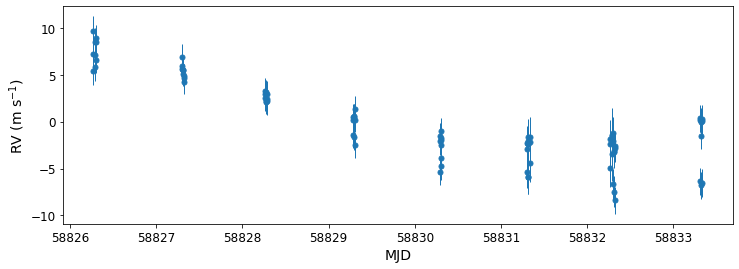

In [38]:
plt.errorbar(data.dates, results.star_time_rvs - np.mean(results.star_time_rvs), 
                     results.star_time_sigmas,
                    fmt='o', ms=5, elinewidth=1)
plt.xlabel('MJD')
plt.ylabel(r'RV (m s$^{-1}$)');

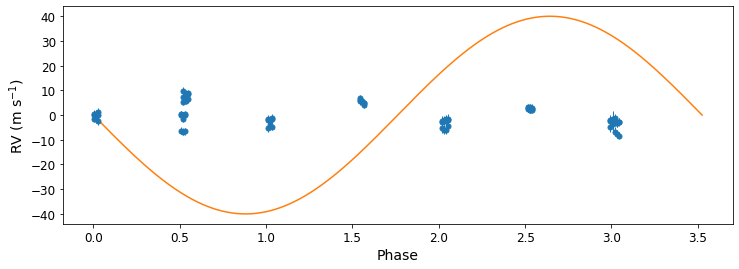

In [20]:
per = 3.52474859
xsin = np.linspace(0, per, 1000)    # do we see the HD 209458 signal? (not in GJ 908 data we don't.)
ysin = -40*np.sin(xsin/per*2*np.pi)

plt.errorbar(np.mod(data.dates-56196.28834, per), results.star_time_rvs - np.mean(results.star_time_rvs), 
                     results.star_time_sigmas,
                    fmt='o', ms=5, elinewidth=1)

plt.plot(xsin, ysin)

plt.xlabel('Phase')
plt.ylabel(r'RV (m s$^{-1}$)');


In [21]:
results.bervs

array([-16145.05, -16145.05, -16145.05, -16182.18, -16182.18, -16182.18,
       -16222.54, -16222.54, -16222.54, -16556.74, -16556.74, -16556.74,
       -16590.91, -16590.91, -16590.91, -16623.79, -16623.79, -16623.79,
       -16824.62, -16824.62, -16824.62, -16854.99, -16854.99, -16854.99,
       -16886.09, -16886.09, -16886.09, -17192.  , -17192.  , -17192.  ,
       -17222.85, -17222.85, -17222.85, -17256.24, -17256.24, -17256.24,
       -17550.03, -17550.03, -17550.03, -17584.04, -17584.04, -17584.04,
       -17615.31, -17615.31, -17615.31, -17906.14, -17906.14, -17906.14,
       -17939.82, -17939.82, -17939.82, -17969.94, -17969.94, -17969.94,
       -18005.64, -18005.64, -18005.64, -18147.69, -18147.69, -18147.69,
       -18188.04, -18188.04, -18188.04, -18232.17, -18232.17, -18232.17,
       -18266.73, -18266.73, -18266.73, -18299.09, -18299.09, -18299.09,
       -18575.6 , -18575.6 , -18575.6 , -18613.07, -18613.07, -18613.07,
       -18652.86, -18652.86, -18652.86])

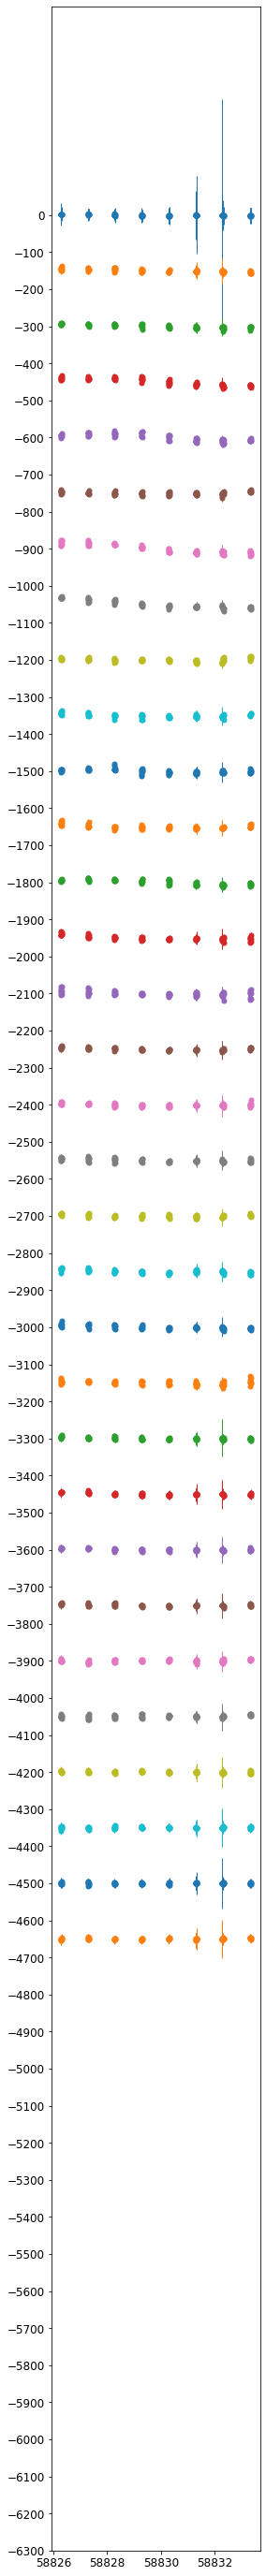

In [22]:
plt.figure(figsize=(4,50))
for i in range(32):
    plt.errorbar(data.dates, results.star_rvs[i] - 150*i-np.mean(results.star_rvs[i]), 
                         1/np.sqrt(results.star_ivars_rvs[i]),
                        fmt='o', ms=5, elinewidth=1)
    
    plt.yticks(np.arange(-6300, 100, 100))

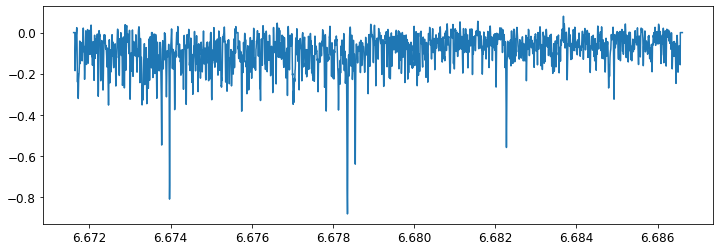

In [32]:
plt.plot(results.star_template_xs[42],results.star_template_ys[42])

Let's see what orders are the noisiest relative to the other orders:

Text(0, 0.5, 'Excess Jitter')

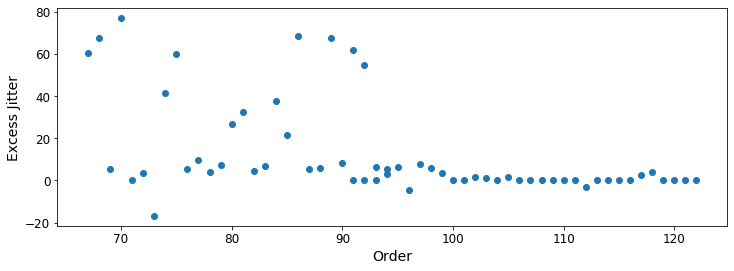

In [39]:
R = data.orders + 0
R += 91
R[32:] -= 56
plt.plot(R, results.star_order_jitters, 'o')
plt.xlabel('Order')
plt.ylabel('Excess Jitter')

We can remove those orders and re-fit.

In [40]:
best_ords = data.orders[np.abs(results.star_order_jitters) < 2]

In [41]:
best_ords

array([ 0,  1,  2,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23,
       24, 25, 28, 29, 30, 31, 36])

2
Desired error not necessarily achieved due to precision loss.


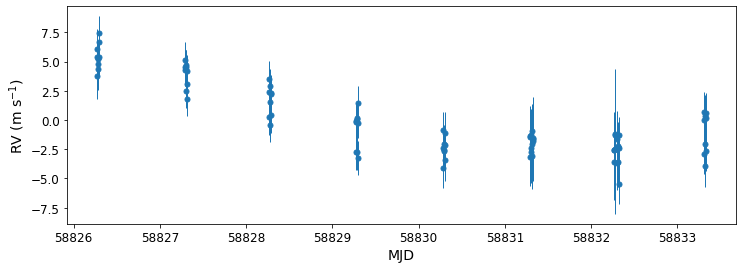

In [42]:
results.combine_orders('star', orders=best_ords)
#results.apply_bervs('star') # we've already applied the bervs above.

plt.errorbar(data.dates, results.star_time_rvs - np.mean(results.star_time_rvs), 
                     results.star_time_sigmas,
                    fmt='o', ms=5, elinewidth=1)
plt.xlabel('MJD')
plt.ylabel(r'RV (m s$^{-1}$)');

Text(0, 0.5, 'Excess Jitter')

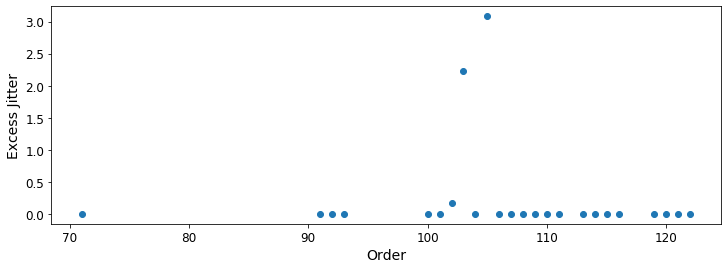

In [43]:
R = data.orders + 0
R += 91
R[32:] -= 56
plt.plot(R[best_ords], results.star_order_jitters, 'o')
plt.xlabel('Order')
plt.ylabel('Excess Jitter')